#TRABAJO PARCIAL: REGLAS DE ASOCIACIÓN


```
                                         COD:
ALUMNOS:     PÉREZ TOMAYLLA, BRUNO            130322
             QUISPE TACURI, RUDI              161135
```



# 0. Paquetes necesarios

In [ ]:
import pandas as pd
import numpy as np
import itertools as it

# 1. Importación de datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importamos la database con Numpy
DB = np.load('/content/drive/MyDrive/Colab Notebooks/2022-I/Minería de datos/Apriori_Algorithm/spotify.npy', allow_pickle=True)
# Conversión de Array a List
auxArray = DB.tolist()
auxList = [auxArray[i] for i in auxArray]

In [ ]:
len(auxList)

10000

# 2. Módulos auxiliares

## 2.0. Generador de ItemSets candidatos

In [ ]:
def Possible_ItemSet_Generator(Older_ItemSet):
    # Creamos un arreglo que contenga a todos los ItemSets candidatos
    Pos_Itemset = []
    # Se realiza la operación de X ∪ Y sobre los items
    for k in range(0,len(Older_ItemSet)-1):
        for j in range(k+1,len(Older_ItemSet)):
            Possible_Item = sorted(list(set(Older_ItemSet[k]+Older_ItemSet[j])))
            # Si los padres tenían n-1 elementos, entonces el hijo es considerado un ItemSet
            if(len(Possible_Item)==len(Older_ItemSet[0])+1 
               and Possible_Item not in Pos_Itemset):
                Pos_Itemset.append(Possible_Item)
    return Pos_Itemset

## 2.1. Contador de ocurrencias de un ItemSet

In [ ]:
def ItemSet_Incidence_Counter(Pos_Itemset, Dataset):
    # Se crea un contador
    aux_Count = [0]*len(Pos_Itemset)
    # Usaremos un ciclo anidado para contar las incidencias
    for k in range(len(Pos_Itemset)):       
        Item = Pos_Itemset[k]
        # Se recorre el DataSet en busca de una ocurrencia
        for tupla in Dataset:
            # Unimos cada elemento con el posible ItemSet
            tupla = set(tupla)
            temp = list(set(Item).union(tupla))
            tupla = list(tupla)
            # Si tienen la misma dimensión, entonces se actualiza el contador
            if(len(temp)==len(tupla)):
                aux_Count[k]+=1
    return aux_Count

## 2.2. Módulo de depuración de ItemSets

Esta función tendrá como objetivo depurar aquellos ItemSets cuyo Confidence no supere el umbral

In [ ]:
def ItemSet_Debugging(Itemset,Values,umbral):
    Valid_Items = []
    # Solo se añadirán aquellos valores que sean mayores o iguales al umbral
    for current_value in Values:
        Valid_Items.append(current_value>=umbral)
    # Se crean dos listas que solo contendrán elementos que hayan superado el requisito anterior
    clean_ItemSet = list(it.compress(Itemset,Valid_Items))
    clean_values = list(it.compress(Values,Valid_Items))
    return clean_ItemSet,clean_values

## 2.3. Módulo de generación de reglas posibles

Esta función obtendrá algunas posibles reglas de asociación

In [ ]:
def Get_Possible_Rules(item):
    # Se crea una lista de objetos de tuplas que contienen todas las permutaciones posibles
    combinations = list(it.permutations(item))
    # Inicializamos arreglos de antecedentes y consecuentes
    current_antecedents = []
    current_consequents = []
    # Analizamos cada permutación
    for tupla in combinations:
        tupla = list(tupla)
        for k in range(1,len(tupla)):
            # De acuerdo a la regla X -> Y, se separan dos variables
            X, Y = tupla[:k],tupla[k:]
            # Ordenamos y añadimos a los arreglos de antecedentes y consecuentes
            X.sort() 
            Y.sort()
            current_antecedents.append(X)
            current_consequents.append(Y)
    return current_antecedents,current_consequents

## 2.4. Módulo para depuración de reglas

Este módulo se encargará de eliminar las reglas repetidas

In [ ]:
def Repeated_Rules_Cleaning(X,Y):
    # Se crea un arreglo booleano de tamaño len(X)
    valids = [True]*len(X)    
    for k in range(len(X)-1):
        # Vemos si el valor actual es válido
        if(valids[k]):
            for j in range(k+1,len(X)):
                # Verificamos si existe un valor repetido
                if(valids[j] and X[k] == X[j] and Y[k] == Y[j]):
                    valids[j]=False
    # Solo se actualizarán las listas con aquellos elementos válidos
    X = list(it.compress(X,valids))
    Y = list(it.compress(Y,valids))
    return X,Y

# 3. Módulos principales

## 3.0. Módulo para conseguir los Itemsets frecuentes

Recibe la estructura de datos que contiene a las playlists y retorna una estructura con los itemsets frecuentes, bajo un umbral mínimo de confianza.

In [ ]:
def get_frequent_itemsets(playlists, min_support):
    # arreglos
    ItemsetTotal = [] # guardaar todos los itens
    ValuesTotals = [] # guardar valores generales
    #Arreglos para obtener los itemset
    Itemset = []      # guardar lo intems en una nueva transaccion 
    ValuesItem = []
    iteration=1       # numro de iteraciones de la lista
    #Ordenamiento
    print(' __________________________________')
    print('|           Computing...           |')
    print(' ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾')
    print('|  Itemsets of length: %2i'%(iteration))
    # Recorremos los Itemset de las transaciones 
    for Transaction in playlists:
      # recorremos los elementos de cada Itemset
        for item in Transaction:
          # convertimos en una cadena 
            item = str(item)
            # Determinar si el k-itemset se encuenra en el itemset de las ranssacciones guardadas
            if(item in Itemset):
              # Incrementar ItensetValues
                ValuesItem[Itemset.index(item)]+=1
            else:
              # Agregar k-itenset
                Itemset.append(item)
                ValuesItem.append(1)
    #determinar longitud del play lista
    PlayListLong = len(playlists)
    # normalizar los datos del playlist
    ValuesItem= [x/PlayListLong for x in ValuesItem]
    #realizar una poda de los datos que no pasan 
    valid_itemset,valid_values= ItemSet_Debugging(Itemset,ValuesItem,min_support)
    # realizar un orden d los valores 
    temp_duplas = dict(zip(valid_itemset,valid_values)).items()
    # arreglos 
    valid_itemset = []
    valid_values = []
    # guardar duplas de los item
    for dupla in sorted(temp_duplas):
      # agregar ala validacion del itemset
        valid_itemset.append(dupla[0])
        valid_values.append(dupla[1])
    #Itemset con mayor numero
    last_itemset = [[x] for x in valid_itemset]
    print("|    Done! → Found items: (%i)"%(len(last_itemset)))
    #Comprovamos 
    while(True):
      # si el tamaño del iemset es igual a 0 termina el proceso
        if(len(last_itemset)==0):
            break
        # caso contrario agrega al itemset total
        ItemsetTotal.append(last_itemset)
        ValuesTotals.append(valid_values)
        # si el tamaño es igual a 1 termina el proceso
        if(len(last_itemset)==1):
            break 
        # incrementa la iteracion    
        iteration+=1
        print('|  Itemsets of length: %2i'%(iteration))
        Pos_Itemset = Possible_ItemSet_Generator(last_itemset)
        Val_PosItems = ItemSet_Incidence_Counter(Pos_Itemset,playlists)                 
        #Valores acumulados, normalizado
        Val_PosItems= [x/PlayListLong for x in Val_PosItems]
        #Eliminar los itemset que no pasan el umbral del minsupot
        last_itemset, valid_values = ItemSet_Debugging(Pos_Itemset,Val_PosItems,min_support)
        print("|    Done! → Found items: (%i)"%(len(last_itemset)))
    return ItemsetTotal,ValuesTotals

## 3.1. Módulo para generar la reglas de asociación

Se reciben todos los ItemSets y da inicio un proceso de:
*   Combinaciones - Permutaciones
*   Depuración 
*   Cálculo de métricas

In [ ]:
def generate_association_rules(frequent_itemsets, confidence = 0, lift =0):
    # Arrego para todas reglas que tienen un minsuport 
    All_rules = []
    # Arreglo par guardar los lift
    All_lift = []
    #arreglo para guardar las confianzas
    All_confidence = []
    # Arreglo de lo support
    All_support = []
    #reglas 
    Long_rule = 2
    # obtener el primer k-itemset del antesendente 
    itemsets = frequent_itemsets[0]
    #obtener el segundo k itemser del antesedente
    itemsvalues = frequent_itemsets[1]
    # lista del antesensente
    Antesedente = []
    # lista del consecuente
    Consecuente = []
    print(' ________________________________________________')
    print('|       Combining all possible rules...          |')
    #Obtencion de todas las reglas 
    while(Long_rule <= len(itemsets)):
       # determinar el ulimo elemento del antesedente 
        itemset_actual = itemsets[Long_rule-1]
        for item in itemset_actual:
           # determinar los item
            xante,yconse = Get_Possible_Rules(item)
            # determinar los item al antsendente
            Antesedente+=xante
            # Agregar al consecuente
            Consecuente+=yconse
        # increento del tamñao de la regla
        Long_rule+=1    
    print('|       Debugging repeated rules...              |')
    #eliminar regla repetidas
    Antesedente,Consecuente = Repeated_Rules_Cleaning(Antesedente,Consecuente)
    print('|       Estimating Lift & Confidence...          |')
    print('|‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾|')
    print('|                    DONE!                       |')
    print(' ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾')
    # calulo del fit y confianza 
    for k in range(len(Antesedente)):
        x = Antesedente[k]
        y = Consecuente[k]
        # agrega datos al consecuente
        _AntecdetConsecuent = x+y
        # realizar un ordenamiento
        _AntecdetConsecuent.sort()
        # posicion cambia al consecuente
        Position = itemsets[len(x)-1].index(x)
        # Posicion del antesendente 
        PosiAntesedent = itemsvalues[len(x)-1][Position]
        # posicion del itemset
        Position = itemsets[len(y)-1].index(y)
        # item que que envia al consecuente
        PosiConsecuent = itemsvalues[len(y)-1][Position]
        # posicion 
        Position = itemsets[len(_AntecdetConsecuent)-1].index(_AntecdetConsecuent)
        P_AntecdetConsecuent = itemsvalues[len(_AntecdetConsecuent)-1][Position]
        #Calculamos la confianza y el lift
        confianza_act = P_AntecdetConsecuent/PosiAntesedent
        lift_act = P_AntecdetConsecuent/PosiAntesedent/PosiConsecuent
        #determinamos is pasa el humbral
        if(lift_act >= lift and confianza_act >= confidence):
            All_rules.append([x,y])
            # agrgar las confianzas
            All_confidence.append(confianza_act)
            # agregar la metrica del lift
            All_lift.append(lift_act)
            # determinar del supor 
            All_support.append(P_AntecdetConsecuent)
            
    return  All_rules,All_confidence,All_lift,All_support

# 4. Fase de ejecución

## 4.1. Ejecutamos los módulos principales

In [ ]:
#@title Ingrese el valor del min_Support { form-width: "50%" }

Support = 0.016 #@param {type:"slider", min:0, max:0.05, step:0.001}

total_Itemsets,total_valores = get_frequent_itemsets(auxList, Support)

 __________________________________
|           Computing...           |
 ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
|  Itemsets of length:  1
|    Done! → Found items: (313)
|  Itemsets of length:  2
|    Done! → Found items: (12)
|  Itemsets of length:  3
|    Done! → Found items: (0)


Imprimimos todos los ItemSets que encontramos

In [ ]:
print(f' ______________________________________________________________')
print(f'|   \t\t Maximum length found: {len(total_Itemsets)}\t\t       |')
print(f' ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾')
print()
# Lista de ItemSets encontrados
for k in range(len(total_Itemsets)):
    print(' __________________________________')
    print('|          Length : %3i            |'%(k+1))
    print(' ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾')
    for j in range(len(total_Itemsets[k])):
        print('%3.2f \t || \t %s '%(total_valores[k][j]*100,total_Itemsets[k][j]))

 ______________________________________________________________
|   		 Maximum length found: 2		       |
 ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

 __________________________________
|          Length :   1            |
 ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
1.72 	 || 	 ["'Till I Collapse"] 
1.63 	 || 	 ['0 To 100 / The Catch Up'] 
2.64 	 || 	 ['1-800-273-8255'] 
1.68 	 || 	 ['24K Magic'] 
2.46 	 || 	 ['679 (feat. Remy Boyz)'] 
1.97 	 || 	 ['7 Years'] 
1.71 	 || 	 ['Africa'] 
2.14 	 || 	 ['Again'] 
2.33 	 || 	 ["Ain't No Mountain High Enough"] 
2.33 	 || 	 ['Alive'] 
2.34 	 || 	 ['All I Want'] 
1.88 	 || 	 ['All My Friends'] 
1.66 	 || 	 ['All Night (feat. Knox Fortune)'] 
1.68 	 || 	 ['All Star'] 
1.65 	 || 	 ['All The Small Things'] 
1.92 	 || 	 ['All Time Low'] 
2.41 	 || 	 ['All of Me'] 
2.15 	 || 	 ['Alone'] 
2.81 	 || 	 ['Alright'] 
2.25 	 || 	 ['Angel'] 
2.64 	 || 	 ['Antidote'] 
1.67 	 || 	 ['Back To Back'] 
3.53 	 || 	 ['Bad and Boujee (feat. Lil Uzi Vert)'

Seguidamente, procedemos a calcular las Reglas de Asociación

In [ ]:
Reglas,Confianza,Lift,Soporte = generate_association_rules([total_Itemsets,total_valores],0.5,10)

 ________________________________________________
|       Combining all possible rules...          |
|       Debugging repeated rules...              |
|       Estimating Lift & Confidence...          |
|‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾|
|                    DONE!                       |
 ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾


## 4.2. Mostramos las reglas

In [ ]:
df = pd.DataFrame(Reglas)
df = df.rename_axis('index').reset_index()
df.set_index('index',inplace=True)
df['Support'] = Soporte
df['Confidence'] = Confianza
df['Lift'] = Lift
df

,0,1,Support,Confidence,Lift
index,,,,,
0,[Bounce Back],[Bad and Boujee (feat. Lil Uzi Vert)],0.0169,0.563333,15.958451
1,[Congratulations],[HUMBLE.],0.0214,0.521951,11.105345
2,[Mask Off],[Congratulations],0.0162,0.512658,12.503859
3,[XO TOUR Llif3],[Congratulations],0.0179,0.542424,13.229860
4,[DNA.],[HUMBLE.],0.0190,0.818966,17.424798
5,[Mask Off],[HUMBLE.],0.0204,0.645570,13.735524
6,[XO TOUR Llif3],[HUMBLE.],0.0204,0.618182,13.152805
7,[goosebumps],[HUMBLE.],0.0167,0.542208,11.536336
8,[Mask Off],[XO TOUR Llif3],0.0163,0.515823,15.630993


# 5. Análisis de los resultados

## 5.0. Explicación de las reglas obtenidas

‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
*    REGLA Nº: 5
*    REGLA: [DNA.] →	[HUMBLE.] 	
*    SUPPORT:    0.0190 	 	
*    CONFIDENCE: 0.818966
*    LIFT:       17.424798
*    EXPLICACIÓN:Dado que los usuarios de spotfy escuchan DNA(musica del grupo BTS ) tambien tienden los usuarios a escuchar el tema HUMBLE(musica del artista Kendrick Lamar),que en el 1.90% de las 10000 transacciones se eligieron a DNA y HUMBLE en la reproducion del playlist. De un 81.89% de lo casos donde se escucho DNA el usuario tambien escucho HUMBLE.


‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
*    REGLA Nº: 6
*    REGLA: [Mask Off] →	[HUMBLE.]
*    SUPPORT:    0.0204 	 	
*    CONFIDENCE: 0.645570
*    LIFT:       13.735524
*    EXPLICACIÓN: Dado que los usuarios de potify que prefieren Mask Off(artista Future) tambien tienden la preferencia del tema HUMBLE(artista Kendrick Lamar), que en un 2.04% de las transacciones de eligieron ambos temas musicales. De un 64.55% de los casos donde se escucho el tema Mask Off el usuario tambien prefirio el tema HUMBLE. 
 
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
*    REGLA Nº: 7
*    REGLA: [XO TOUR Llif3] →	[HUMBLE.]
*    SUPPORT: 0.0204	
*    CONFIDENCE: 0.618182
*    LIFT: 13.152805
*    EXPLICACIÓN:Dado que los usuarios de potify que prefieren XO TOUR Llif3(artista ) tambien tienden la preferencia del tema HUMBLE(artista Kendrick Lamar),que en un 2.04% de las transacciones de eligieron ambos temas musicales. De un 61.81% de los casos donde se escucho el tema XO TOUR Llif3 el usuario tambien prefirio el tema HUMBLE.
 
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
*    REGLA Nº: 1
*    REGLA: [Bounce Back] → [Bad and Boujee (feat. Lil Uzi Vert)]	
*    SUPPORT: 0.0169	
*    CONFIDENCE: 0.563333
*    LIFT:15.958451
*    EXPLICACIÓN:Dado que los usuarios de spotfy escuchan Bounce Back(musica del grupo BTS ) tambien tienden los usuarios a escuchar el tema Bad and Boujee (feat. Lil Uzi Vert),que en el 1.90% de las 10000 transacciones se eligieron a habos temas nusicales en la reproducion del playlist. De un 81.89% de lo casos donde se escucho DNA el usuario tambien escucho Bad and Boujee (feat. Lil Uzi Vert).
 
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

f## 5.1. WordCloud

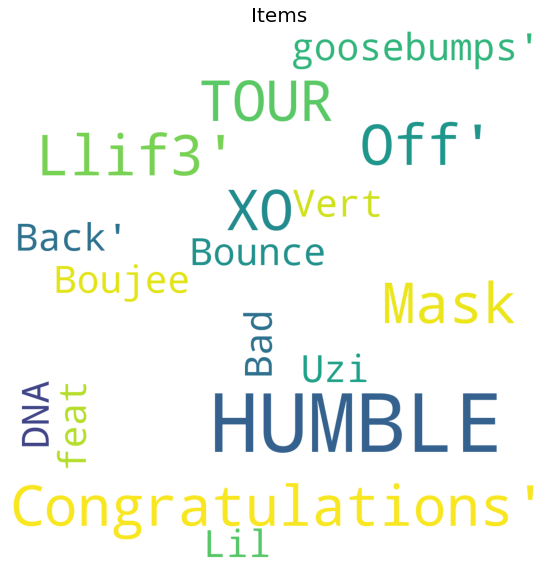

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

plt.rcParams['figure.figsize'] = (10,10)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 121).generate(str(Reglas))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Items',fontsize = 20)
plt.show()



*   Podemos ver que
*   Que el itemset con mayor confianza es el tema musical HUMBLE que tiene un aproximado de un 82%  
*   Que el itemset que tiene confiana  con un 60 % es XO TOUR Llif3 




## 5.2. Support vs Confidence

In [ ]:
import plotly.express as px

fig=px.scatter(df['Support'], df['Confidence'])
fig.update_layout(
    xaxis_title="support",
    yaxis_title="confidence",
   
    font_family="Courier New",
    font_color="blue",
    title_font_family="Times New Roman",
    title_font_color="red",
    title=('Support vs Confidence')
    
)

fig.show()

## 5.3. Lift vs Confidence

Text(0.5, 1.0, 'lift vs Confidence')

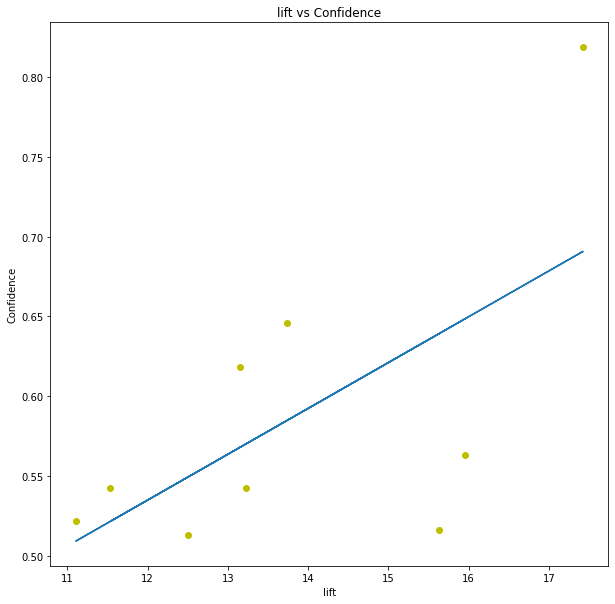

In [ ]:
fit = np.polyfit(df['Lift'], df['Confidence'], 1)
fit_fn = np.poly1d(fit)
plt.plot(df['Lift'], df['Confidence'], 'yo', df['Lift'], 
fit_fn(df['Lift']))
plt.xlabel('lift')
plt.ylabel('Confidence')
plt.title('lift vs Confidence')